In [18]:
import sys
from os.path import abspath
sys.path.insert(0, abspath('..'))

from os.path import join

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from tabulate import tabulate

import torch
from torchSTC.data import load_data
from torchSTC.modules import STC
from torchSTC.metrics import SpacePlot, Evaluate
from torchSTC.utils import SphericalKmeans



plot = SpacePlot()
eval = Evaluate()

In [3]:
cur = abspath("")
dataset = 'Biomedical'
data_in_dir=join(cur, "../..", "datasets")
dataset_dir=join(data_in_dir, dataset)

In [4]:
checkpoint_dir=join(dataset_dir, 
                    "artefacts",
                    "STC-d48:500:500:2000:20-epoch15-datBiomedical-wdeWord2Vec-scaMinMax-tfeSIF-normNone-initKmeans"
                    )

checkpoint = "STC-datBiomedical-wdeWord2Vec-scaMinMax-tfeSIF-normNone-initKmeans.pth"
checkpoint_path = join(checkpoint_dir, checkpoint)
checkpoint_path

'/home/godwin/Documents/academic/PPD/torchSTC/demos/Biomedical/../../datasets/Biomedical/artefacts/STC-d48:500:500:2000:20-epoch15-datBiomedical-wdeWord2Vec-scaMinMax-tfeSIF-normNone-initKmeans/STC-datBiomedical-wdeWord2Vec-scaMinMax-tfeSIF-normNone-initKmeans.pth'

In [5]:
x, y = load_data(dataset=dataset_dir, word_emb='Word2Vec', transform='SIF', scaler='MinMax', norm=None)
n_clusters = len(torch.unique(torch.tensor(y)))

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)

# conversion des données en tenseurs
X_train = torch.tensor(X_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

stc = STC(hidden_dims=[torch.Tensor(X_train).shape[-1], 500, 500, 2000, 20], n_clusters=n_clusters)
stc.from_pretrained(checkpoint_path)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

### Embedding started...
Test w2v ==> ==> ==> 
#### SIF embedding started...
SIF-Embedding 19999 documents with 48-dimensional word vectors...
SVD decomposition...
### SIF embedding completed...
### Embedding completed...
[embed_docs] XX shape:  (20000, 48)
MinMax scaling completed...
No normalization applied...


(torch.Size([18000, 48]),
 torch.Size([2000, 48]),
 torch.Size([18000]),
 torch.Size([2000]))

In [6]:
z2 = stc.autoencoder.encoder(X_train)

In [20]:
# table for results display
table = []

In [17]:
# comprehension list with 5 runs of kmeans, get average and std of metrics
avg_w2v_mmx_ikm2 = []
tmp = []
for i in range(5):
    kmeans = KMeans(n_clusters=n_clusters, n_init=50)
    kmeans.fit(z2.detach().numpy())
    y_km_pred = kmeans.labels_
    tmp.append(eval.allMetrics(y_train.detach().numpy(), y_km_pred))

avg_w2v_mmx_ikm2 = np.array(tmp)
mt21 = np.round(avg_w2v_mmx_ikm2.mean(axis=0), 3) * 100
std_mt21 = avg_w2v_mmx_ikm2.std(axis=0)

mt21, std_mt21

(array([46.2, 37.1, 27.1]),
 array([1.01980390e-04, 4.89897949e-05, 1.01980390e-04]))

In [22]:
table.append(["hgf-stc-w2v_mmx_ikm2"]+[x for x in mt21])

In [16]:
avg_w2v_mmx_iskm2 = []
tmp = []
for i in range(5):
    skmeans = SphericalKmeans(n_clusters=n_clusters, n_init=50)
    skmeans.fit(z2.detach().numpy())
    y_skm_pred = skmeans.labels_
    tmp.append(eval.allMetrics(y_train.detach().numpy(), y_skm_pred))

avg_w2v_mmx_iskm2 = np.array(tmp)

mt22 = np.round(avg_w2v_mmx_iskm2.mean(axis=0), 3) * 100
std_mt22 = avg_w2v_mmx_iskm2.std(axis=0)
mt22, std_mt22

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iter

(array([44.1, 36.1, 26.1]), array([0.01110812, 0.00530939, 0.00630955]))

In [23]:
table.append(["hgf-stc-w2v_mmx_iskm2"]+[x for x in mt22])

In [24]:
###############################################################################
# Print all results in table
headers = [
    "ACC",
    "NMI",
    "ARI"
]
print(tabulate(table, headers, tablefmt="fancy_grid"))

╒═══════════════════════╤═══════╤═══════╤═══════╕
│                       │   ACC │   NMI │   ARI │
╞═══════════════════════╪═══════╪═══════╪═══════╡
│ hgf-stc-w2v_mmx_ikm2  │  46.2 │  37.1 │  27.1 │
├───────────────────────┼───────┼───────┼───────┤
│ hgf-stc-w2v_mmx_iskm2 │  44.1 │  36.1 │  26.1 │
╘═══════════════════════╧═══════╧═══════╧═══════╛


### Visualisation

In [9]:
kmeans = KMeans(n_clusters=n_clusters, n_init=50)
kmeans.fit(z2.detach().numpy())
y_km_pred2 = kmeans.labels_


skmeans = SphericalKmeans(n_clusters=n_clusters, n_init=50)
skmeans.fit(z2.detach().numpy())
y_skm_pred2 = skmeans.labels_

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iter

In [10]:
print(min(y_km_pred2), len(np.unique(y_km_pred2)), max(y_km_pred2))
print(min(y_skm_pred2), len(np.unique(y_skm_pred2)), max(y_skm_pred2))

0 20 19
0 20 19


In [11]:
eval.allMetrics(y_train.detach().numpy(), y_km_pred2)

[0.4624, 0.371, 0.2712]

In [12]:
eval.allMetrics(y_train.detach().numpy(), y_skm_pred2)

[0.4234, 0.3613, 0.2586]

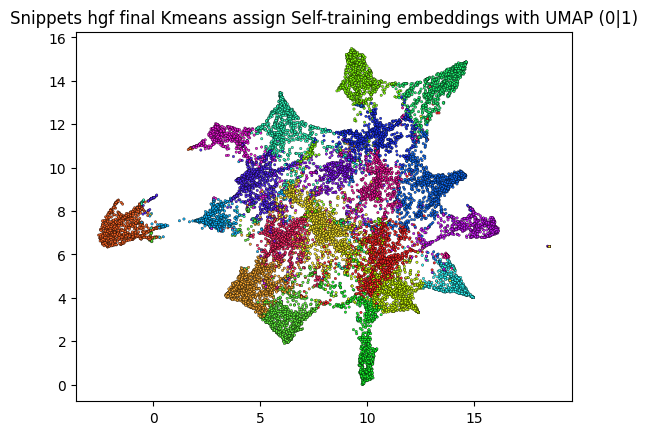

In [13]:
plot.commonSpace_plot(z2.detach().numpy(), comp=[0, 1], tagLabels=y_km_pred2,
                      data_name="Snippets hgf final Kmeans assign", dimred = 'UMAP')

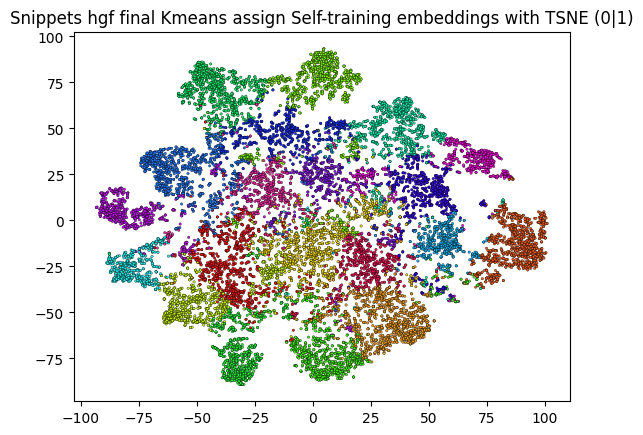

In [14]:
plot.commonSpace_plot(z2.detach().numpy(), comp=[0, 1], tagLabels=y_km_pred2,
                      data_name="Snippets hgf final Kmeans assign", dimred = 'TSNE')